In [4]:
from yggdrasil import tools
from yggdrasil.runner import run
import trimesh

# One way model-to-model connection

To instead direct the heights to the light model from above, we then use an updated version of the `yamls/connections_v0.yml` YAML (diff displayed below). This can be in same file or a new one as the model, but is separate here to keep output modular.

In [2]:
tools.display_source_diff('yamls/connections_v0.yml', 'yamls/connections_v1.yml', number_lines=True)

file1: yamls/connections_v0.yml
file2: yamls/connections_v1.yml
 1:   connections:
    -   - input:
 2: +   - input: shoot:height
    ?                                +++++++++++++

    -       name: ../input/light_v0.txt
    -       filetype: table
 3:       output: light:input
 4:     - input: light:output
 5:       output:
 6:         name: ../output/light_v0.txt
 7:         filetype: table
 8:         field_names: [intensity]



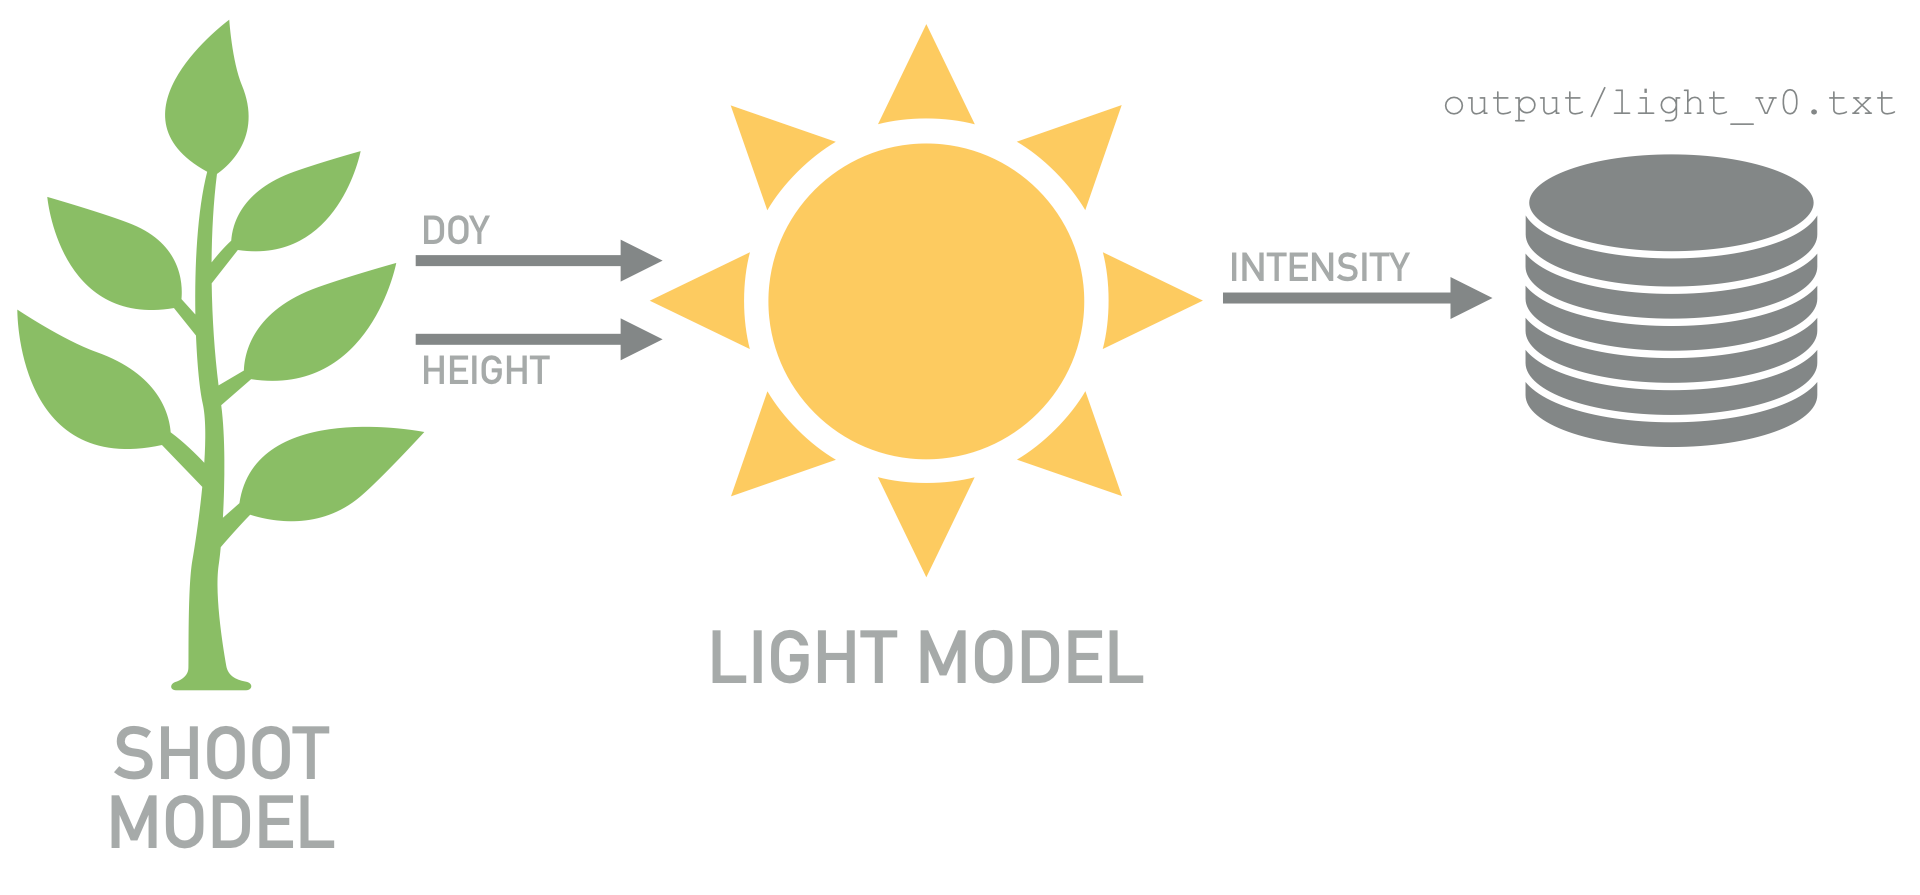

To run this integration, we then pass 3 YAMLs: the light model YAML, the shoot model YAML, and the shoot-to-light connection YAML.

In [3]:
run(['yamls/light_v0_python.yml', 'yamls/shoot_v1.yml', 'yamls/connections_v1.yml'], production_run=True)

INFO:78048:runner.startDrivers[499]:YggRunner(runner): Starting I/O drivers and models on system Meagans-MacBook-Air.local in namespace yggdrasil with rank 0
/Users/langmm/miniconda3/envs/conda36/bin/python /Users/langmm/yggdrasil/yggdrasil/demos/CiS2021-hackathon/models/ygg_light_v0.py
/Users/langmm/miniconda3/envs/conda36/bin/python /Users/langmm/yggdrasil/yggdrasil/demos/CiS2021-hackathon/models/shoot_v1.py 0.0 48.0 6.0
End of input from temp_doy.
INFO:78048:runner.waitModels[553]:YggRunner(runner): shoot finished running.
INFO:78048:runner.waitModels[559]:YggRunner(runner): shoot finished exiting.
INFO:78048:runner.waitModels[553]:YggRunner(runner): light finished running.
INFO:78048:runner.waitModels[559]:YggRunner(runner): light finished exiting.
INFO:78048:runner.waitModels[573]:YggRunner(runner): All models completed
INFO:78048:runner.run[374]:YggRunner(runner):                 init	0.000001
INFO:78048:runner.run[374]:YggRunner(runner):         load drivers	0.329309
INFO:78048:

The next two cells display the mesh from the final time step and the contents of the resulting `output/light_v0.txt` file.

In [5]:
mesh = trimesh.load_mesh('output/mesh_008.obj')
mesh.show()

In [6]:
tools.display_source('output/light_v0.txt')

file: output/light_v0.txt
# intensity
# erg/(cm**2*s)
# %g
618082
648331
681333
717477
757224
801131
849874
904281
965376




# Remote Procedure Call (RPC)

The previous example achieves the goal of connecting the two models, but it is not particularly powerful in this case given that the same could be received by saving the heights from the shoot to a file that can be read by the light model. However, if we want the shoot model to incorporate the light intensity into the calculation of how fast the shoot should grow, then we need to be able to dynamically access the output from the light model at each time step which cannot be accomplished via files. Instead we need the plant model to call the light model at each timestep via a remote procedure call (RPC). The client model (shoot model) sends requests to the server model (light model) and then receives the response via the `call` method.

The diff displayed by the cell below shows the updated version of the shoot model where
1. The `YggRpcClient` interface function is used instead of `YggOutput`
1. The channel name used to complete the connection is `light_shoot` which comes from the name of the two models (`<server>_<client>`)
1. The time and height are sent to the light model via the `call` method which returns the output from the light model (intensity).
1. The scale factor used to grow the shoot mesh is computed based on the light intensity return by the light model

In [7]:
tools.display_source_diff('models/shoot_v1.py', 'models/shoot_v2.py', number_lines=True)

file1: models/shoot_v1.py
file2: models/shoot_v2.py
 1:   import os
 2:   import trimesh
 3:   import argparse
 4:   
 5:   _dir = os.path.dirname(os.path.realpath(__file__))
 6:   
 7:   # Parse command-line arguments
 8:   parser = argparse.ArgumentParser("Simulate a shoot's growth over time.")
 9:   parser.add_argument('tmin', help='Starting time (in hours)', type=float)
10:   parser.add_argument('tmax', help='Ending time (in hours)', type=float)
11:   parser.add_argument('tstep', help='Time step (in hours)', type=float)
12:   parser.add_argument('--meshfile', help='Path to file where mesh is stored.',
13:                       default='../meshes/plants-2.obj')
14:   args = parser.parse_args()
15:   tmin = args.tmin
16:   tmax = args.tmax
17:   tstep = args.tstep
18:   mesh = trimesh.load_mesh(args.meshfile)
19:   
20:   # Set initial conditions
21:   mass = 2000.0
22:   t = tmin
23:   i = 0
24:   
25:   # Check if model is running as a part of an yggdrasil integration
26:   with_yg

To run this integration, two key modification need to be made to the model YAMLs as shown in the diffs below:
1. Add the `is_server: true` parameter to the light model YAML to declare that it is a server
1. Add the `client_of: [light]` parameter to the shoot model YAML to tell yggdrasil that it will be calling the light model server as a client

Since yggdrasil handles the server-client connections, no connection YAML is required.

In [8]:
tools.display_source_diff('yamls/shoot_v1.yml', 'yamls/shoot_v2.yml', number_lines=True)
tools.display_source_diff('yamls/light_v0_python.yml', 'yamls/light_v1_python.yml', number_lines=True)

file1: yamls/shoot_v1.yml
file2: yamls/shoot_v2.yml
 1:   model:
 2:     name: shoot
 3:     language: python
    -   args: [../models/shoot_v1.py, 0.0, 48.0, 6.0]
    ?                                                          ^

 4: +   args: [../models/shoot_v2.py, 0.0, 48.0, 6.0]
    ?                                                          ^

    -   outputs:
    -     - name: height
    ?  ----               ^^^          ^^

 5: +   client_of: light
    ?                ++++ ^^^^          ^

    -       default_file:
    -         name: ../output/height.txt
    -         filetype: table

file1: yamls/light_v0_python.yml
file2: yamls/light_v1_python.yml
 1:   model:
 2:     name: light
 3:     language: python
 4:     args: ../models/light_v0.py
 5:     function: light
 6: +   is_server: true



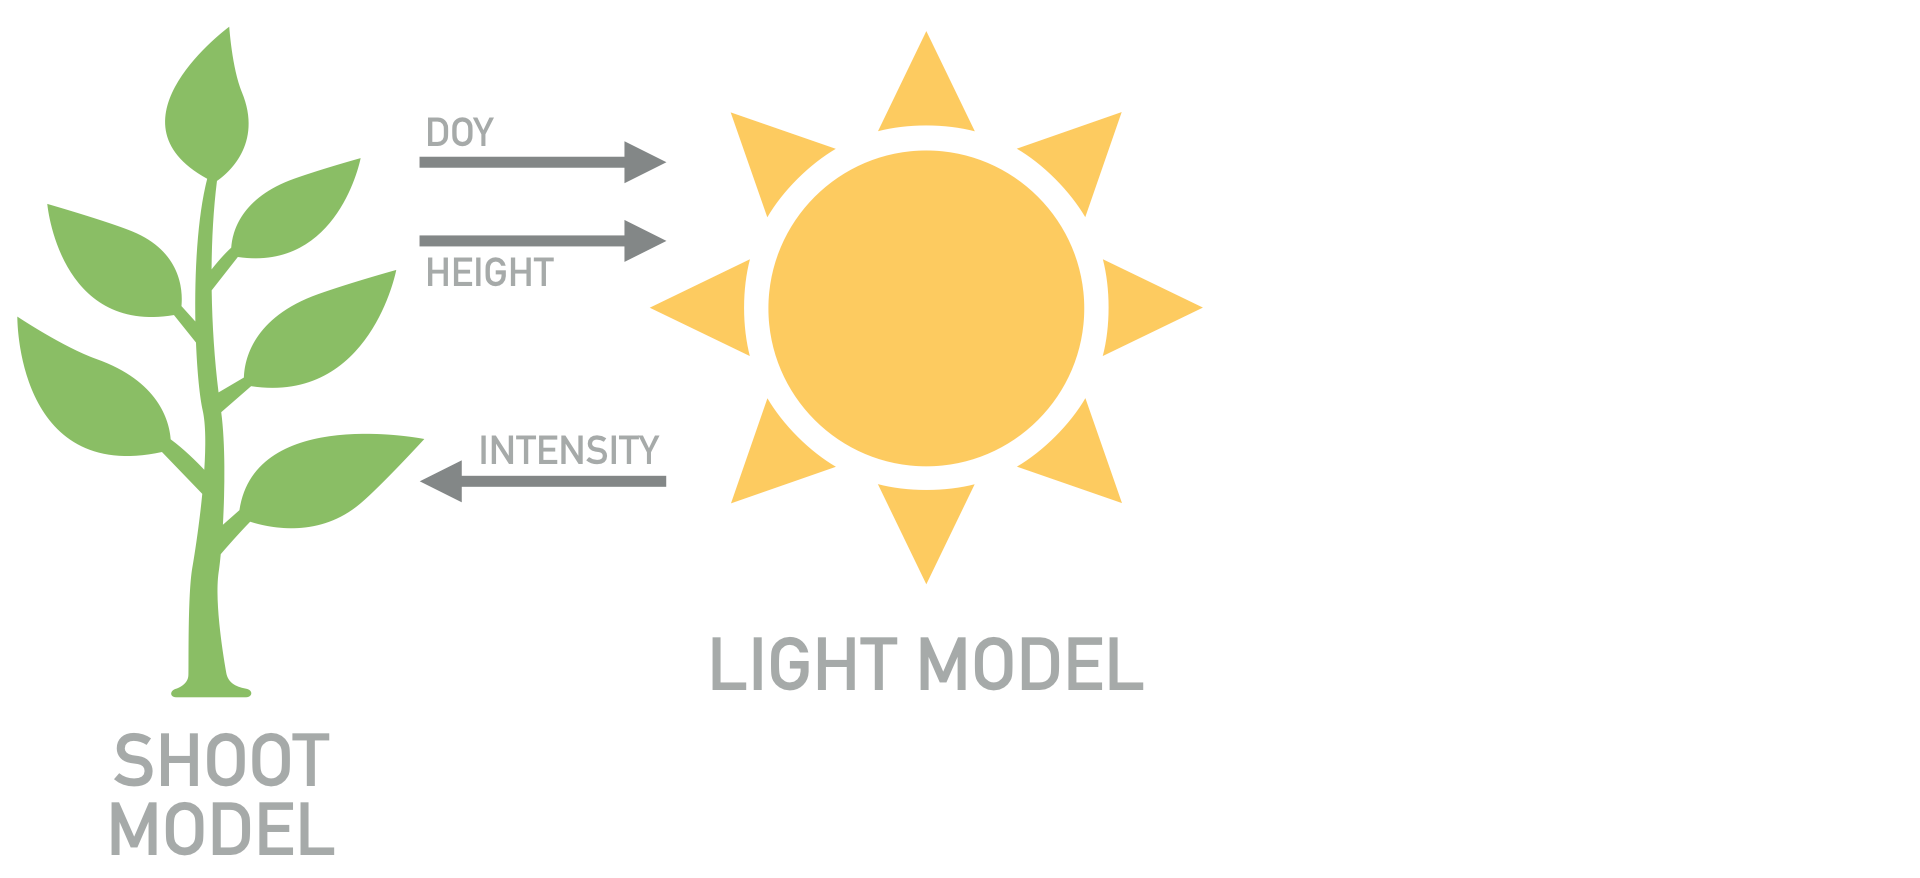

The cell below runs the shoot-light RPC integration using these YAML files and displays the resulting mesh.

In [9]:
run(['yamls/light_v1_python.yml', 'yamls/shoot_v2.yml'], production_run=True)
mesh = trimesh.load_mesh('output/mesh_008.obj')
mesh.show()

INFO:78048:runner.startDrivers[499]:YggRunner(runner): Starting I/O drivers and models on system Meagans-MacBook-Air.local in namespace yggdrasil with rank 0
/Users/langmm/miniconda3/envs/conda36/bin/python /Users/langmm/yggdrasil/yggdrasil/demos/CiS2021-hackathon/models/ygg_light_v0.py
/Users/langmm/miniconda3/envs/conda36/bin/python /Users/langmm/yggdrasil/yggdrasil/demos/CiS2021-hackathon/models/shoot_v2.py 0.0 48.0 6.0
End of input from temp_doy.
INFO:78048:runner.waitModels[553]:YggRunner(runner): light finished running.
INFO:78048:runner.waitModels[559]:YggRunner(runner): light finished exiting.
INFO:78048:runner.waitModels[553]:YggRunner(runner): shoot finished running.
INFO:78048:runner.waitModels[559]:YggRunner(runner): shoot finished exiting.
INFO:78048:runner.waitModels[573]:YggRunner(runner): All models completed
INFO:78048:runner.run[374]:YggRunner(runner):                 init	0.000001
INFO:78048:runner.run[374]:YggRunner(runner):         load drivers	0.011610
INFO:78048:

## Splitting Calls
Client (and timesync as we will discuss later) "calls" are really a combination of a send and receive (sending the request and receiving the response). If call's take a long amount of time, we can split the call into its components to take advantage of the parallelism yggdrasil offers. A client (or timesync comm) can call send a request, finish another unrelated task while the server/sync operation takes place, and then call receive to get the response. For example, the `call` to the light model in the previous example could be split between a send and receive call:

In [10]:
tools.display_source_diff('models/shoot_v2.py', 'models/shoot_v2_split.py', number_lines=True)

file1: models/shoot_v2.py
file2: models/shoot_v2_split.py
 1:   import os
 2:   import trimesh
 3:   import argparse
 4:   
 5:   _dir = os.path.dirname(os.path.realpath(__file__))
 6:   
 7:   # Parse command-line arguments
 8:   parser = argparse.ArgumentParser("Simulate a shoot's growth over time.")
 9:   parser.add_argument('tmin', help='Starting time (in hours)', type=float)
10:   parser.add_argument('tmax', help='Ending time (in hours)', type=float)
11:   parser.add_argument('tstep', help='Time step (in hours)', type=float)
12:   parser.add_argument('--meshfile', help='Path to file where mesh is stored.',
13:                       default='../meshes/plants-2.obj')
14:   args = parser.parse_args()
15:   tmin = args.tmin
16:   tmax = args.tmax
17:   tstep = args.tstep
18:   mesh = trimesh.load_mesh(args.meshfile)
19:   
20:   # Set initial conditions
21:   mass = 2000.0
22:   t = tmin
23:   i = 0
24:   
25:   # Check if model is running as a part of an yggdrasil integration
26:   w

In [11]:
run(['yamls/light_v1_python.yml', 'yamls/shoot_v2_split.yml'], production_run=True)
mesh = trimesh.load_mesh('output/mesh_008.obj')
mesh.show()

INFO:78048:runner.startDrivers[499]:YggRunner(runner): Starting I/O drivers and models on system Meagans-MacBook-Air.local in namespace yggdrasil with rank 0
/Users/langmm/miniconda3/envs/conda36/bin/python /Users/langmm/yggdrasil/yggdrasil/demos/CiS2021-hackathon/models/ygg_light_v0.py
/Users/langmm/miniconda3/envs/conda36/bin/python /Users/langmm/yggdrasil/yggdrasil/demos/CiS2021-hackathon/models/shoot_v2_split.py 0.0 48.0 6.0
End of input from temp_doy.
INFO:78048:runner.waitModels[553]:YggRunner(runner): light finished running.
INFO:78048:runner.waitModels[559]:YggRunner(runner): light finished exiting.
INFO:78048:runner.waitModels[553]:YggRunner(runner): shoot finished running.
INFO:78048:runner.waitModels[559]:YggRunner(runner): shoot finished exiting.
INFO:78048:runner.waitModels[573]:YggRunner(runner): All models completed
INFO:78048:runner.run[374]:YggRunner(runner):                 init	0.000001
INFO:78048:runner.run[374]:YggRunner(runner):         load drivers	0.011233
INFO:

# Duplicating Models

Splitting calls can be particularly powerful if you are making many calls to a server model and the server model evaluation does not depend on previous calls. In such cases, multiple copies of the server model can be run in parallel and respond to requests in parallel.

The diff displayed in cell below modifies the `models/shoot_v2_split.py` version of the shoot model so that it calculates an intensity for every vertex in the shoot mesh and saves the intensity array to a file as a Python pickle. Requests are sent for every vertex before beginning to receive any responses.

In [12]:
tools.display_source_diff('models/shoot_v2_split.py', 'models/shoot_v2_copies.py', number_lines=True)

file1: models/shoot_v2_split.py
file2: models/shoot_v2_copies.py
 1:   import os
 2:   import trimesh
 3:   import argparse
 4:   
 5:   _dir = os.path.dirname(os.path.realpath(__file__))
 6:   
 7:   # Parse command-line arguments
 8:   parser = argparse.ArgumentParser("Simulate a shoot's growth over time.")
 9:   parser.add_argument('tmin', help='Starting time (in hours)', type=float)
10:   parser.add_argument('tmax', help='Ending time (in hours)', type=float)
11:   parser.add_argument('tstep', help='Time step (in hours)', type=float)
12:   parser.add_argument('--meshfile', help='Path to file where mesh is stored.',
13:                       default='../meshes/plants-2.obj')
14:   args = parser.parse_args()
15:   tmin = args.tmin
16:   tmax = args.tmax
17:   tstep = args.tstep
18:   mesh = trimesh.load_mesh(args.meshfile)
19:   
20:   # Set initial conditions
21:   mass = 2000.0
22:   t = tmin
23:   i = 0
24:   
25:   # Check if model is running as a part of an yggdrasil integration


To run 2 copies of the light model, the `copies: 2` line can be added to the light YAML from above as shown in the diff the cell below displays.

In [13]:
tools.display_source_diff('yamls/light_v1_python.yml', 'yamls/light_v2_python.yml', number_lines=True)

file1: yamls/light_v1_python.yml
file2: yamls/light_v2_python.yml
 1:   model:
 2:     name: light
 3:     language: python
 4:     args: ../models/light_v0.py
 5:     function: light
 6:     is_server: true
 7: +   copies: 2



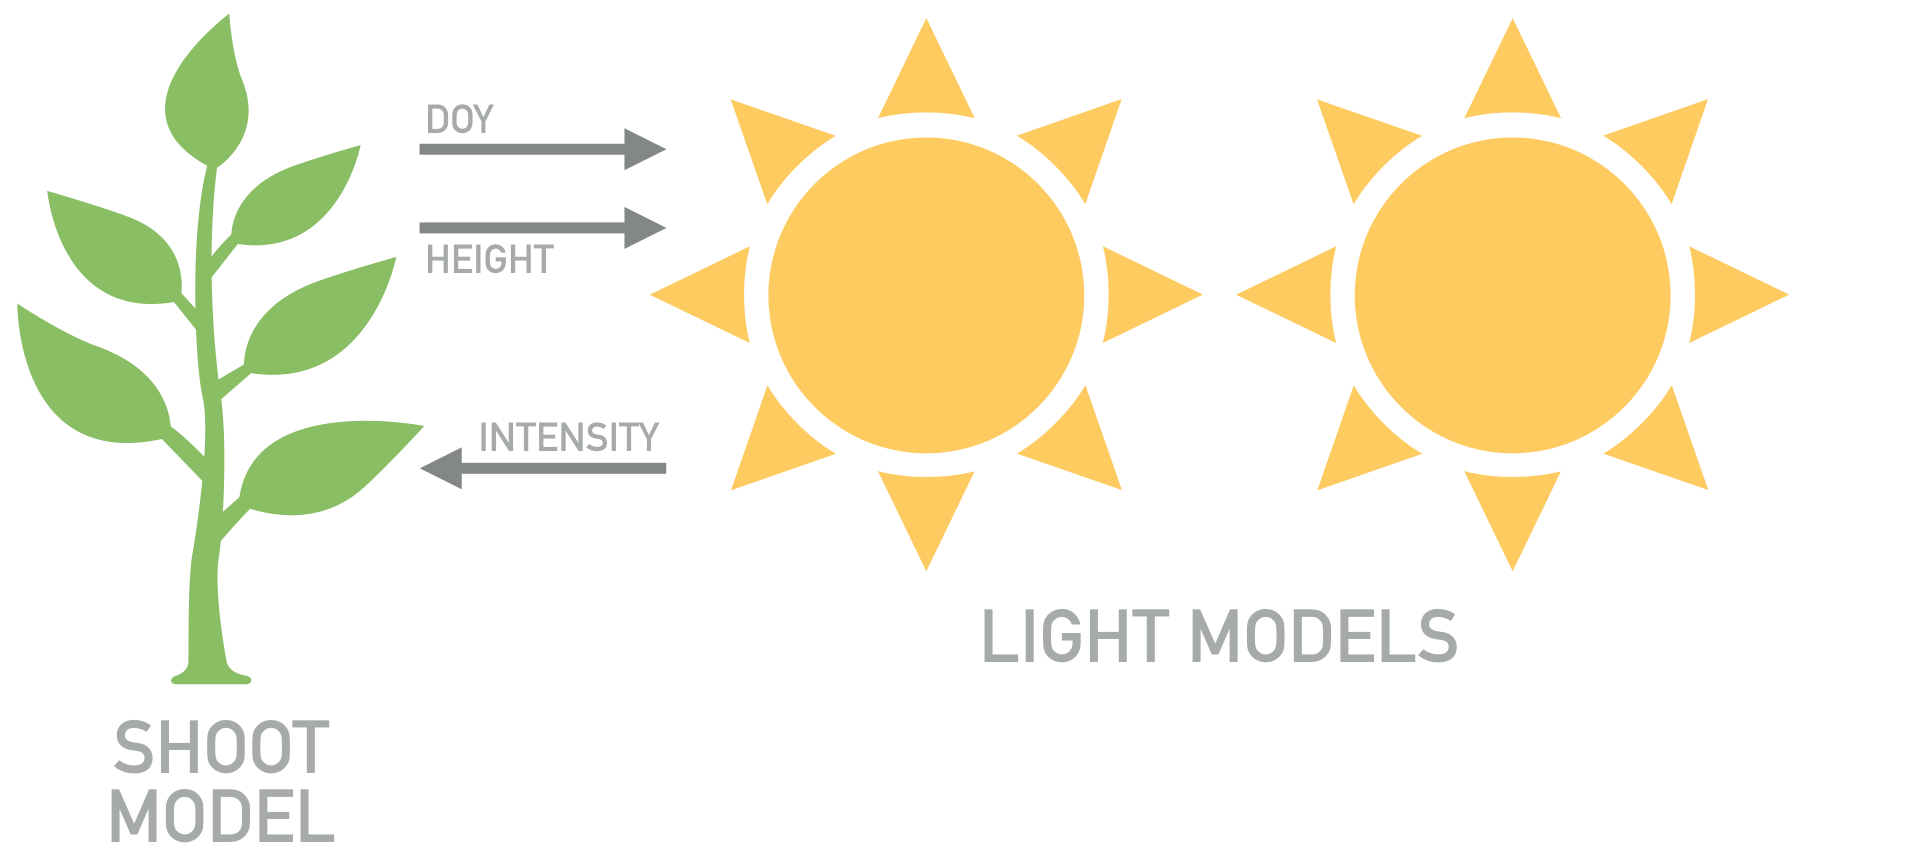

To run this integration, you would pass 2 YAMLS to yggdrasil:
1. The plant model YAML with that outputs heights for every vertex
1. The light model YAML with the `server` and `copies` parameters

The next shell runs this integration and displays the resulting mesh.

In [14]:
run(['yamls/light_v1_python.yml', 'yamls/shoot_v2_copies.yml'], production_run=True)

# Plot results w/ light intensity mapped to color
import pickle
with open('output/light_008.pkl', 'rb') as fd:
    light = pickle.load(fd)
mesh = trimesh.load_mesh('output/mesh_008.obj')
mesh.visual.vertex_colors = trimesh.visual.interpolate(light/max(light))
mesh.show()

INFO:78048:runner.startDrivers[499]:YggRunner(runner): Starting I/O drivers and models on system Meagans-MacBook-Air.local in namespace yggdrasil with rank 0
/Users/langmm/miniconda3/envs/conda36/bin/python /Users/langmm/yggdrasil/yggdrasil/demos/CiS2021-hackathon/models/ygg_light_v0.py
/Users/langmm/miniconda3/envs/conda36/bin/python /Users/langmm/yggdrasil/yggdrasil/demos/CiS2021-hackathon/models/shoot_v2_copies.py 0.0 48.0 6.0
End of input from temp_doy.
INFO:78048:runner.waitModels[553]:YggRunner(runner): light finished running.
INFO:78048:runner.waitModels[559]:YggRunner(runner): light finished exiting.
INFO:78048:runner.waitModels[553]:YggRunner(runner): shoot finished running.
INFO:78048:runner.waitModels[559]:YggRunner(runner): shoot finished exiting.
INFO:78048:runner.waitModels[573]:YggRunner(runner): All models completed
INFO:78048:runner.run[374]:YggRunner(runner):                 init	0.000001
INFO:78048:runner.run[374]:YggRunner(runner):         load drivers	0.016928
INFO

## Parallelism inside MyBinder
Unless you install the materials locally, your notebook is being hosted by the MyBinder service. Although yggdrasil attempts to run the models in parallel, there is essentially only 1 core available on the instances provided (for free) by MyBinder so integrations run on MyBinder instances are not really running in parallel (they are running concurrently so one can run while the other is waiting for an asynchronous call to return, but the models must share the CPU). If you were to download the demo repository and run the notebook on your machine, you would see much better performance from all of the integrations involving more than one model as they would actually run in parallel.